In [21]:
# Cell 1: Imports and Environment Setup
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from torch.cuda.amp import autocast, GradScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from pathlib import Path
import json
import time
import xml.etree.ElementTree as ET
from datetime import datetime
from tqdm.auto import tqdm
import cv2
from PIL import Image, ImageDraw
import timm

# ML libraries
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict, Counter
import random

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True

def monitor_gpu_memory():
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        cached = torch.cuda.memory_reserved() / 1024**3
        free = torch.cuda.get_device_properties(0).total_memory / 1024**3 - cached
        print(f"GPU Memory - Allocated: {allocated:.1f}GB | Cached: {cached:.1f}GB | Free: {free:.1f}GB")

def clear_gpu_cache():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("GPU cache cleared")

print("Environment setup completed!")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060
GPU Memory: 12.0 GB
Environment setup completed!


In [22]:
# Cell 2: Configuration and Dataset Paths
class Config:
    # Dataset paths - MODIFY THESE TO MATCH YOUR DATASET LOCATION
    PROJECT_ROOT = Path(r"C:\Users\labuser\Desktop\Steel_Defect_Detection")
    DATA_ROOT = PROJECT_ROOT / "NEU-DET"
    IMAGES_DIR = DATA_ROOT / "images"
    ANNOTATIONS_DIR = DATA_ROOT / "annotations"
    
    # Output directories
    CHECKPOINTS_DIR = PROJECT_ROOT / "checkpoints_detection"
    RESULTS_DIR = PROJECT_ROOT / "results_detection"
    LOGS_DIR = PROJECT_ROOT / "logs_detection"
    
    # Steel defect classes
    DEFECT_CLASSES = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
    NUM_CLASSES = 6
    CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(DEFECT_CLASSES)}
    IDX_TO_CLASS = {idx: cls for idx, cls in enumerate(DEFECT_CLASSES)}
    
    # K-Fold settings
    N_FOLDS = 5
    RANDOM_STATE = 42
    
    # Few-shot learning settings for small datasets
    DATA_PERCENTAGES = [1, 2, 5, 10, 20, 50, 100]
    SAMPLES_PER_CLASS = {
        1: 3,      # 3 samples per class (18 total)
        2: 6,      # 6 samples per class (36 total)
        5: 15,     # 15 samples per class (90 total)
        10: 30,    # 30 samples per class (180 total)
        20: 60,    # 60 samples per class (360 total)
        50: 150,   # 150 samples per class (900 total)
        100: -1    # All available data
    }
    
    # Model configuration
    BACKBONE_NAME = "swin_small_patch4_window7_224"
    IMAGE_SIZE = 224
    PROJECTION_DIM = 256
    HIDDEN_DIM = 512
    TEMPERATURE = 0.07
    
    # Training configuration (optimized for small datasets)
    BATCH_SIZE = 8  # Smaller for better gradient estimates with limited data
    NUM_WORKERS = 2
    PIN_MEMORY = True
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 0.01
    
    # Training epochs (reduced for faster K-fold)
    CONTRASTIVE_EPOCHS = 10
    DETECTION_EPOCHS = 20
    
    # Data augmentation
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]
    
    # Detection specific
    CONFIDENCE_THRESHOLD = 0.5
    NMS_THRESHOLD = 0.3
    MAX_DETECTIONS_PER_IMAGE = 10
    
    @classmethod
    def create_directories(cls):
        """Create all necessary directories"""
        for directory in [cls.CHECKPOINTS_DIR, cls.RESULTS_DIR, cls.LOGS_DIR]:
            directory.mkdir(parents=True, exist_ok=True)
        print(f"Created directories at: {cls.PROJECT_ROOT}")

# Initialize configuration
config = Config()
config.create_directories()

print("Configuration loaded successfully!")
print(f"Project root: {config.PROJECT_ROOT}")
print(f"Data root: {config.DATA_ROOT}")
print(f"Images directory: {config.IMAGES_DIR}")
print(f"Annotations directory: {config.ANNOTATIONS_DIR}")
print(f"Number of classes: {config.NUM_CLASSES}")
print(f"Classes: {config.DEFECT_CLASSES}")
print(f"K-folds: {config.N_FOLDS}")
print(f"Data percentages to test: {config.DATA_PERCENTAGES}")

# Verify dataset exists
if config.IMAGES_DIR.exists():
    image_count = len(list(config.IMAGES_DIR.glob("*.jpg")))
    print(f"Found {image_count} images in dataset")
else:
    print(f"WARNING: Images directory not found at {config.IMAGES_DIR}")
    print("Please update the PROJECT_ROOT and DATA_ROOT paths in the Config class")

if config.ANNOTATIONS_DIR.exists():
    annotation_count = len(list(config.ANNOTATIONS_DIR.glob("*.xml")))
    print(f"Found {annotation_count} annotation files")
else:
    print(f"WARNING: Annotations directory not found at {config.ANNOTATIONS_DIR}")
    print("This is needed for bounding box detection training")

Created directories at: C:\Users\labuser\Desktop\Steel_Defect_Detection
Configuration loaded successfully!
Project root: C:\Users\labuser\Desktop\Steel_Defect_Detection
Data root: C:\Users\labuser\Desktop\Steel_Defect_Detection\NEU-DET
Images directory: C:\Users\labuser\Desktop\Steel_Defect_Detection\NEU-DET\images
Annotations directory: C:\Users\labuser\Desktop\Steel_Defect_Detection\NEU-DET\annotations
Number of classes: 6
Classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
K-folds: 5
Data percentages to test: [1, 2, 5, 10, 20, 50, 100]
Found 1800 images in dataset
Found 1800 annotation files


Testing augmentation and annotation parsing...
Augmentation pipeline created successfully!
Looking for examples of each defect type...

Searching for crazing defects...
Found localized crazing in crazing_10.jpg with 2 objects

Searching for inclusion defects...
Found localized inclusion in inclusion_1.jpg with 4 objects

Searching for patches defects...
Found localized patches in patches_1.jpg with 3 objects

Searching for pitted_surface defects...
Found localized pitted_surface in pitted_surface_1.jpg with 2 objects

Searching for rolled-in_scale defects...
Found localized rolled-in_scale in rolled-in_scale_1.jpg with 2 objects

Searching for scratches defects...
Found localized scratches in scratches_1.jpg with 2 objects

Found examples for 6 defect types

Visualizing defect examples...


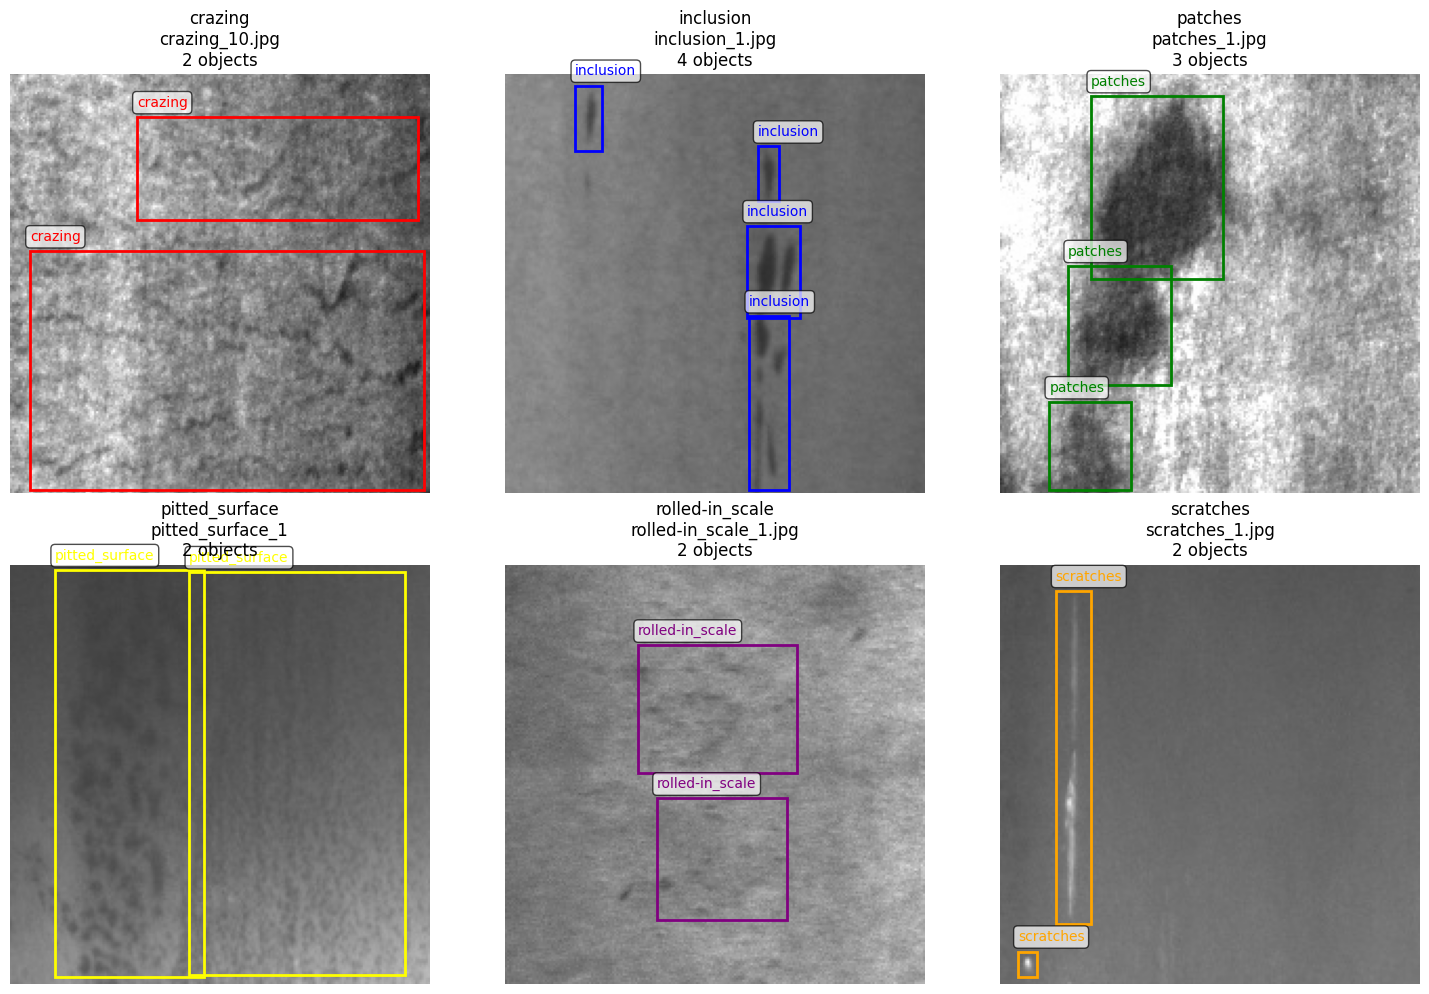


Augmentation test results:
Contrastive shape: torch.Size([3, 224, 224])
Train shape: torch.Size([3, 224, 224])
Validation shape: torch.Size([3, 224, 224])
All augmentation modes working correctly!
Augmentation and preprocessing setup completed!


In [25]:
# Cell 3: Data Augmentation and Preprocessing

class SteelDefectAugmentation:
    
    def __init__(self, image_size=224, mode='classification'):
        self.image_size = image_size
        self.mode = mode
        
        # Contrastive learning augmentations
        self.contrastive_transform = A.Compose([
            A.Resize(image_size + 32, image_size + 32),
            A.RandomCrop(image_size, image_size),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.6),
            A.GaussNoise(var_limit=(5, 25), p=0.3),
            A.MotionBlur(blur_limit=3, p=0.2),
            A.GridDistortion(num_steps=5, distort_limit=0.1, p=0.2),
            A.RandomGamma(gamma_limit=(80, 120), p=0.3),
            A.CLAHE(clip_limit=2.0, tile_grid_size=(4, 4), p=0.3),
            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=15, p=0.3),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.2),
            A.Rotate(limit=15, p=0.4),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.3),
            A.Normalize(mean=config.IMAGENET_MEAN, std=config.IMAGENET_STD),
            ToTensorV2()
        ])
        
        # Classification training augmentations
        self.train_transform = A.Compose([
            A.Resize(image_size + 16, image_size + 16),
            A.RandomCrop(image_size, image_size),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.GaussNoise(var_limit=(5, 15), p=0.2),
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=10, p=0.3),
            A.CLAHE(clip_limit=1.5, p=0.2),
            A.Normalize(mean=config.IMAGENET_MEAN, std=config.IMAGENET_STD),
            ToTensorV2()
        ])
        
        # Detection training augmentations
        self.detection_transform = A.Compose([
            A.Resize(image_size, image_size),
            A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.4),
            A.GaussNoise(var_limit=(3, 10), p=0.2),
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=5, p=0.2),
            A.Normalize(mean=config.IMAGENET_MEAN, std=config.IMAGENET_STD),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))
        
        # Validation transform
        self.val_transform = A.Compose([
            A.Resize(image_size, image_size),
            A.Normalize(mean=config.IMAGENET_MEAN, std=config.IMAGENET_STD),
            ToTensorV2()
        ])
        
        # Validation transform for detection
        self.val_detection_transform = A.Compose([
            A.Resize(image_size, image_size),
            A.Normalize(mean=config.IMAGENET_MEAN, std=config.IMAGENET_STD),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))
    
    def __call__(self, image, mode='train', bboxes=None, class_labels=None):
        if mode == 'contrastive':
            return self.contrastive_transform(image=image)['image']
        
        elif mode == 'detection':
            if bboxes is not None and class_labels is not None:
                if len(bboxes) > 0:
                    transformed = self.detection_transform(
                        image=image, 
                        bboxes=bboxes, 
                        class_labels=class_labels
                    )
                    return transformed['image'], transformed['bboxes'], transformed['class_labels']
                else:
                    transformed = self.val_transform(image=image)
                    return transformed['image'], [], []
            else:
                transformed = self.val_detection_transform(
                    image=image, 
                    bboxes=bboxes or [], 
                    class_labels=class_labels or []
                )
                return transformed['image'], transformed['bboxes'], transformed['class_labels']
        
        elif mode == 'train':
            return self.train_transform(image=image)['image']
        
        else:
            return self.val_transform(image=image)['image']


class AnnotationParser:
    
    @staticmethod
    def parse_xml_annotation(xml_path):
        if not xml_path.exists():
            return None
            
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        filename = root.find('filename').text if root.find('filename') is not None else xml_path.stem + '.jpg'
        
        size_elem = root.find('size')
        if size_elem is not None:
            width = int(size_elem.find('width').text)
            height = int(size_elem.find('height').text)
        else:
            width, height = 200, 200
        
        bboxes = []
        class_labels = []
        
        for obj in root.findall('object'):
            class_name = obj.find('name').text
            if class_name not in config.CLASS_TO_IDX:
                continue
                
            class_idx = config.CLASS_TO_IDX[class_name]
            
            bbox = obj.find('bndbox')
            if bbox is not None:
                xmin = float(bbox.find('xmin').text)
                ymin = float(bbox.find('ymin').text)
                xmax = float(bbox.find('xmax').text)
                ymax = float(bbox.find('ymax').text)
                
                xmin = max(0, min(xmin, width))
                ymin = max(0, min(ymin, height))
                xmax = max(xmin + 1, min(xmax, width))
                ymax = max(ymin + 1, min(ymax, height))
                
                bboxes.append([xmin, ymin, xmax, ymax])
                class_labels.append(class_idx)
        
        return {
            'filename': filename,
            'width': width,
            'height': height,
            'bboxes': bboxes,
            'class_labels': class_labels,
            'num_objects': len(bboxes)
        }
    
    @staticmethod
    def visualize_annotation(image_path, xml_path, save_path=None):
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        annotation = AnnotationParser.parse_xml_annotation(xml_path)
        if annotation is None:
            print(f"Could not parse annotation: {xml_path}")
            return
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        ax.imshow(image)
        ax.set_title(f"Image: {annotation['filename']}")
        
        colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange']
        
        for bbox, class_idx in zip(annotation['bboxes'], annotation['class_labels']):
            xmin, ymin, xmax, ymax = bbox
            width = xmax - xmin
            height = ymax - ymin
            
            rect = patches.Rectangle(
                (xmin, ymin), width, height,
                linewidth=2, edgecolor=colors[class_idx % len(colors)],
                facecolor='none'
            )
            ax.add_patch(rect)
            
            class_name = config.DEFECT_CLASSES[class_idx]
            ax.text(xmin, ymin - 5, class_name,
                   fontsize=12, color=colors[class_idx % len(colors)],
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))
        
        ax.axis('off')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"Visualization saved to: {save_path}")
        
        plt.show()


print("Testing augmentation and annotation parsing...")

augmentation = SteelDefectAugmentation(image_size=config.IMAGE_SIZE)
print("Augmentation pipeline created successfully!")

if config.IMAGES_DIR.exists() and config.ANNOTATIONS_DIR.exists():
    print("Looking for examples of each defect type...")
    
    # Find one example of each defect class with localized bounding boxes
    defect_examples = {}
    
    for defect_class in config.DEFECT_CLASSES:
        print(f"\nSearching for {defect_class} defects...")
        
        # Look for images of this defect type
        defect_images = list(config.IMAGES_DIR.glob(f"{defect_class}*.jpg"))
        
        if defect_images:
            # Check each image to find one with localized bounding boxes
            for img_path in defect_images[:5]:  # Check first 5 images
                xml_path = config.ANNOTATIONS_DIR / (img_path.stem + '.xml')
                annotation = AnnotationParser.parse_xml_annotation(xml_path)
                
                if annotation and annotation['num_objects'] > 0:
                    # Check if bounding boxes are localized (not full image)
                    has_localized_bbox = False
                    for bbox in annotation['bboxes']:
                        xmin, ymin, xmax, ymax = bbox
                        bbox_width = xmax - xmin
                        bbox_height = ymax - ymin
                        
                        # Consider it localized if bbox is less than 80% of image
                        if bbox_width < annotation['width'] * 0.8 or bbox_height < annotation['height'] * 0.8:
                            has_localized_bbox = True
                            break
                    
                    if has_localized_bbox:
                        defect_examples[defect_class] = {
                            'image_path': img_path,
                            'xml_path': xml_path,
                            'annotation': annotation
                        }
                        print(f"Found localized {defect_class} in {img_path.name} with {annotation['num_objects']} objects")
                        break
            
            if defect_class not in defect_examples:
                # If no localized bbox found, use first image anyway
                img_path = defect_images[0]
                xml_path = config.ANNOTATIONS_DIR / (img_path.stem + '.xml')
                annotation = AnnotationParser.parse_xml_annotation(xml_path)
                if annotation:
                    defect_examples[defect_class] = {
                        'image_path': img_path,
                        'xml_path': xml_path,
                        'annotation': annotation
                    }
                    print(f"Using {img_path.name} for {defect_class} (may have full-image annotation)")
        else:
            print(f"No images found for {defect_class}")
    
    print(f"\nFound examples for {len(defect_examples)} defect types")
    
    # Visualize all found defect examples
    if defect_examples:
        print("\nVisualizing defect examples...")
        
        # Create subplot for all defects
        n_defects = len(defect_examples)
        cols = 3
        rows = (n_defects + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
        if rows == 1:
            axes = [axes] if n_defects == 1 else axes
        else:
            axes = axes.flatten()
        
        colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange']
        
        for idx, (defect_class, data) in enumerate(defect_examples.items()):
            if idx >= len(axes):
                break
                
            ax = axes[idx]
            
            # Load and display image
            image = cv2.imread(str(data['image_path']))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            ax.imshow(image)
            
            annotation = data['annotation']
            ax.set_title(f"{defect_class}\n{annotation['filename']}\n{annotation['num_objects']} objects")
            
            # Draw bounding boxes
            for bbox, class_idx in zip(annotation['bboxes'], annotation['class_labels']):
                xmin, ymin, xmax, ymax = bbox
                width = xmax - xmin
                height = ymax - ymin
                
                rect = patches.Rectangle(
                    (xmin, ymin), width, height,
                    linewidth=2, edgecolor=colors[class_idx % len(colors)],
                    facecolor='none'
                )
                ax.add_patch(rect)
                
                # Add class label
                class_name = config.DEFECT_CLASSES[class_idx]
                ax.text(xmin, ymin - 5, class_name,
                       fontsize=10, color=colors[class_idx % len(colors)],
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))
            
            ax.axis('off')
        
        # Hide unused subplots
        for idx in range(len(defect_examples), len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Test augmentation with first example
        if defect_examples:
            first_example = list(defect_examples.values())[0]
            test_image_path = first_example['image_path']
            
            image = cv2.imread(str(test_image_path))
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                aug_contrastive = augmentation(image, mode='contrastive')
                aug_train = augmentation(image, mode='train')
                aug_val = augmentation(image, mode='val')
                
                print(f"\nAugmentation test results:")
                print(f"Contrastive shape: {aug_contrastive.shape}")
                print(f"Train shape: {aug_train.shape}")
                print(f"Validation shape: {aug_val.shape}")
                print("All augmentation modes working correctly!")
    else:
        print("No defect examples found for visualization")

print("Augmentation and preprocessing setup completed!")

In [27]:
# Cell 4: Dataset Classes

class SteelDefectDataset(torch.utils.data.Dataset):
    def __init__(self, mode='classification', data_percentage=100, fold_indices=None, 
                 split='train', augmentation=None):
        """
        Steel Defect Dataset for classification and detection
        
        Args:
            mode: 'classification', 'detection', 'contrastive'
            data_percentage: Percentage of data to use (1, 2, 5, 10, 20, 50, 100)
            fold_indices: List of indices for K-fold splits
            split: 'train' or 'val'
            augmentation: SteelDefectAugmentation instance
        """
        self.mode = mode
        self.data_percentage = data_percentage
        self.split = split
        self.augmentation = augmentation or SteelDefectAugmentation()
        
        # Load all data first
        self.image_paths, self.annotations = self._load_all_data()
        
        # Apply fold filtering if provided
        if fold_indices is not None:
            self._apply_fold_indices(fold_indices)
        
        # Create balanced subset for small datasets
        if data_percentage < 100:
            self._create_balanced_subset()
        
        print(f"Dataset created: {len(self.image_paths)} images, {data_percentage}% data, {mode} mode, {split} split")
        self._print_class_distribution()
    
    def _load_all_data(self):
        """Load all images and their corresponding annotations"""
        image_paths = []
        annotations = []
        
        for img_path in sorted(config.IMAGES_DIR.glob("*.jpg")):
            xml_path = config.ANNOTATIONS_DIR / (img_path.stem + '.xml')
            
            annotation = AnnotationParser.parse_xml_annotation(xml_path)
            if annotation is not None:
                image_paths.append(img_path)
                annotations.append(annotation)
        
        return image_paths, annotations
    
    def _apply_fold_indices(self, fold_indices):
        """Apply K-fold indices to filter data"""
        self.image_paths = [self.image_paths[i] for i in fold_indices]
        self.annotations = [self.annotations[i] for i in fold_indices]
    
    def _create_balanced_subset(self):
        """Create stratified balanced subset for few-shot learning"""
        samples_per_class = config.SAMPLES_PER_CLASS.get(self.data_percentage, 50)
        
        # Group data by primary class (from filename)
        class_data = defaultdict(list)
        
        for img_path, annotation in zip(self.image_paths, self.annotations):
            # Extract primary class from filename
            primary_class = self._extract_primary_class(img_path.stem)
            if primary_class in config.DEFECT_CLASSES:
                class_data[primary_class].append((img_path, annotation))
        
        # Sample from each class
        subset_paths = []
        subset_annotations = []
        
        for class_name in config.DEFECT_CLASSES:
            if class_name in class_data:
                available_samples = class_data[class_name]
                
                if samples_per_class == -1:
                    selected_samples = available_samples
                else:
                    num_samples = min(samples_per_class, len(available_samples))
                    selected_samples = random.sample(available_samples, num_samples)
                
                for img_path, annotation in selected_samples:
                    subset_paths.append(img_path)
                    subset_annotations.append(annotation)
        
        # Shuffle the final dataset
        combined = list(zip(subset_paths, subset_annotations))
        random.shuffle(combined)
        self.image_paths, self.annotations = zip(*combined)
        self.image_paths = list(self.image_paths)
        self.annotations = list(self.annotations)
    
    def _extract_primary_class(self, filename):
        """Extract primary class from filename"""
        for class_name in config.DEFECT_CLASSES:
            if filename.startswith(class_name):
                return class_name
        return filename.split('_')[0]
    
    def _print_class_distribution(self):
        """Print distribution of classes in the dataset"""
        class_counts = defaultdict(int)
        
        for img_path in self.image_paths:
            primary_class = self._extract_primary_class(img_path.stem)
            if primary_class in config.DEFECT_CLASSES:
                class_counts[primary_class] += 1
        
        print("Class distribution:")
        for class_name in config.DEFECT_CLASSES:
            print(f"  {class_name}: {class_counts[class_name]} samples")
    
    def _load_image(self, image_path):
        """Load and convert image to RGB"""
        image = cv2.imread(str(image_path))
        if image is None:
            raise ValueError(f"Could not load image: {image_path}")
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    def _get_primary_class_label(self, image_path):
        """Get class label from filename"""
        primary_class = self._extract_primary_class(image_path.stem)
        return config.CLASS_TO_IDX.get(primary_class, 0)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        annotation = self.annotations[idx]
        
        # Load image
        image = self._load_image(image_path)
        
        if self.mode == 'classification':
            # Classification mode: return image and class label
            class_label = self._get_primary_class_label(image_path)
            
            if self.split == 'train':
                augmented_image = self.augmentation(image, mode='train')
            else:
                augmented_image = self.augmentation(image, mode='val')
            
            return augmented_image, class_label
        
        elif self.mode == 'contrastive':
            # Contrastive mode: return two augmented views
            view1 = self.augmentation(image, mode='contrastive')
            view2 = self.augmentation(image, mode='contrastive')
            class_label = self._get_primary_class_label(image_path)
            
            return view1, view2, class_label
        
        elif self.mode == 'detection':
            # Detection mode: return image, bboxes, and labels
            bboxes = annotation['bboxes'].copy()
            class_labels = annotation['class_labels'].copy()
            
            if self.split == 'train' and len(bboxes) > 0:
                # Apply detection augmentations
                augmented_image, aug_bboxes, aug_labels = self.augmentation(
                    image, mode='detection', bboxes=bboxes, class_labels=class_labels
                )
                
                # Convert to tensors
                if len(aug_bboxes) > 0:
                    aug_bboxes = torch.tensor(aug_bboxes, dtype=torch.float32)
                    aug_labels = torch.tensor(aug_labels, dtype=torch.long)
                else:
                    aug_bboxes = torch.zeros((0, 4), dtype=torch.float32)
                    aug_labels = torch.zeros((0,), dtype=torch.long)
                
                return augmented_image, aug_bboxes, aug_labels
            else:
                # Validation or no bboxes
                augmented_image = self.augmentation(image, mode='val')
                
                if len(bboxes) > 0:
                    bboxes = torch.tensor(bboxes, dtype=torch.float32)
                    class_labels = torch.tensor(class_labels, dtype=torch.long)
                else:
                    bboxes = torch.zeros((0, 4), dtype=torch.float32)
                    class_labels = torch.zeros((0,), dtype=torch.long)
                
                return augmented_image, bboxes, class_labels
        
        else:
            raise ValueError(f"Unknown mode: {self.mode}")


def create_kfold_splits(n_folds=5, random_state=42):
    """Create stratified K-fold splits for the dataset"""
    print(f"Creating {n_folds}-fold splits...")
    
    # Create a temporary dataset to get all data
    temp_dataset = SteelDefectDataset(mode='classification', data_percentage=100)
    
    # Extract class labels for stratification
    class_labels = []
    for img_path in temp_dataset.image_paths:
        class_label = temp_dataset._get_primary_class_label(img_path)
        class_labels.append(class_label)
    
    # Create stratified splits
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    fold_splits = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(range(len(temp_dataset)), class_labels)):
        fold_splits.append((train_idx.tolist(), val_idx.tolist()))
        
        # Print fold distribution
        train_labels = [class_labels[i] for i in train_idx]
        val_labels = [class_labels[i] for i in val_idx]
        train_counts = Counter(train_labels)
        val_counts = Counter(val_labels)
        
        print(f"Fold {fold_idx+1}: Train={len(train_idx)}, Val={len(val_idx)}")
        print(f"  Train distribution: {dict(train_counts)}")
        print(f"  Val distribution: {dict(val_counts)}")
    
    return fold_splits


def collate_fn_detection(batch):
    """Custom collate function for detection mode"""
    images, bboxes, labels = zip(*batch)
    
    # Stack images
    images = torch.stack(images, 0)
    
    # Keep bboxes and labels as lists (variable length)
    return images, list(bboxes), list(labels)


def create_dataloaders(train_dataset, val_dataset, batch_size=8):
    """Create DataLoaders with appropriate collate functions"""
    
    # Determine collate function based on mode
    if train_dataset.mode == 'detection':
        collate_fn = collate_fn_detection
    else:
        collate_fn = None
    
    # Adjust batch size for small datasets
    train_batch_size = min(batch_size, len(train_dataset))
    val_batch_size = min(batch_size, len(val_dataset))
    
    # Use fewer workers for small datasets to avoid crashes
    num_workers = 0 if len(train_dataset) < 50 else config.NUM_WORKERS
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=config.PIN_MEMORY,
        collate_fn=collate_fn,
        drop_last=True if len(train_dataset) > train_batch_size else False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=val_batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=config.PIN_MEMORY,
        collate_fn=collate_fn
    )
    
    return train_loader, val_loader


# Test the dataset
print("Testing dataset creation...")

# Test with small percentage
test_dataset = SteelDefectDataset(
    mode='classification',
    data_percentage=1,
    split='train',
    augmentation=augmentation
)

print(f"\nTesting data loading...")
sample = test_dataset[0]
print(f"Sample shape: {sample[0].shape}, Label: {sample[1]}")

# Test detection mode
test_detection_dataset = SteelDefectDataset(
    mode='detection',
    data_percentage=1,
    split='train',
    augmentation=augmentation
)

detection_sample = test_detection_dataset[0]
print(f"Detection sample - Image: {detection_sample[0].shape}, Bboxes: {detection_sample[1].shape}, Labels: {detection_sample[2].shape}")

# Test K-fold splits
print(f"\nTesting K-fold splits...")
fold_splits = create_kfold_splits(n_folds=config.N_FOLDS, random_state=config.RANDOM_STATE)
print(f"Created {len(fold_splits)} folds successfully!")

print("Dataset classes ready!")

Testing dataset creation...
Dataset created: 18 images, 1% data, classification mode, train split
Class distribution:
  crazing: 3 samples
  inclusion: 3 samples
  patches: 3 samples
  pitted_surface: 3 samples
  rolled-in_scale: 3 samples
  scratches: 3 samples

Testing data loading...
Sample shape: torch.Size([3, 224, 224]), Label: 4
Dataset created: 18 images, 1% data, detection mode, train split
Class distribution:
  crazing: 3 samples
  inclusion: 3 samples
  patches: 3 samples
  pitted_surface: 3 samples
  rolled-in_scale: 3 samples
  scratches: 3 samples
Detection sample - Image: torch.Size([3, 224, 224]), Bboxes: torch.Size([2, 4]), Labels: torch.Size([2])

Testing K-fold splits...
Creating 5-fold splits...
Dataset created: 1800 images, 100% data, classification mode, train split
Class distribution:
  crazing: 300 samples
  inclusion: 300 samples
  patches: 300 samples
  pitted_surface: 300 samples
  rolled-in_scale: 300 samples
  scratches: 300 samples
Fold 1: Train=1440, Val=

In [30]:
# Cell 5: Model Architectures

class SwinTransformerBackbone(nn.Module):
    def __init__(self, model_name="swin_small_patch4_window7_224", pretrained=True):
        super(SwinTransformerBackbone, self).__init__()
        
        self.backbone = timm.create_model(
            model_name, 
            pretrained=pretrained,
            num_classes=0,
            global_pool=''
        )
        
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            dummy_output = self.backbone.forward_features(dummy_input)
            
            if len(dummy_output.shape) == 4:
                if dummy_output.shape[1] == dummy_output.shape[2]:
                    self.feature_dim = dummy_output.shape[3]
                    self.spatial_dims = (dummy_output.shape[1], dummy_output.shape[2])
                else:
                    self.feature_dim = dummy_output.shape[1]
                    self.spatial_dims = (dummy_output.shape[2], dummy_output.shape[3])
            elif len(dummy_output.shape) == 3:
                self.feature_dim = dummy_output.shape[2]
                seq_len = dummy_output.shape[1]
                spatial_size = int(seq_len ** 0.5)
                self.spatial_dims = (spatial_size, spatial_size)
        
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        print(f"Swin Transformer loaded: {model_name}")
        print(f"Feature dimension: {self.feature_dim}")
        print(f"Spatial dimensions: {self.spatial_dims}")
    
    def forward(self, x, return_spatial=False):
        features = self.backbone.forward_features(x)
        
        if len(features.shape) == 4:
            if features.shape[1] == features.shape[2]:
                spatial_features = features.permute(0, 3, 1, 2)
            else:
                spatial_features = features
        elif len(features.shape) == 3:
            B, L, C = features.shape
            H, W = self.spatial_dims
            spatial_features = features.view(B, H, W, C).permute(0, 3, 1, 2)
        
        if return_spatial:
            return spatial_features
        else:
            pooled_features = self.global_pool(spatial_features)
            return pooled_features.flatten(1)


class ContrastiveProjectionHead(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.1):
        super(ContrastiveProjectionHead, self).__init__()
        
        layers = []
        current_dim = input_dim
        
        for i in range(num_layers - 1):
            layers.extend([
                nn.Linear(current_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout)
            ])
            current_dim = hidden_dim
        
        layers.append(nn.Linear(current_dim, output_dim))
        self.projection = nn.Sequential(*layers)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        return F.normalize(self.projection(x), dim=1)


class ClassificationHead(nn.Module):
    def __init__(self, input_dim, num_classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(input_dim, num_classes)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        return self.classifier(x)


class DetectionHead(nn.Module):
    def __init__(self, input_dim, num_classes, num_anchors=9):
        super(DetectionHead, self).__init__()
        
        self.num_classes = num_classes
        self.num_anchors = num_anchors
        
        self.conv1 = nn.Conv2d(input_dim, 256, 3, padding=1)
        self.conv2 = nn.Conv2d(256, 256, 3, padding=1)
        
        self.cls_head = nn.Conv2d(256, num_anchors * num_classes, 3, padding=1)
        self.bbox_head = nn.Conv2d(256, num_anchors * 4, 3, padding=1)
        self.obj_head = nn.Conv2d(256, num_anchors, 3, padding=1)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        cls_pred = self.cls_head(x)
        bbox_pred = self.bbox_head(x)
        obj_pred = self.obj_head(x)
        
        B, _, H, W = cls_pred.shape
        
        cls_pred = cls_pred.view(B, self.num_anchors, self.num_classes, H, W)
        cls_pred = cls_pred.permute(0, 1, 3, 4, 2).contiguous()
        
        bbox_pred = bbox_pred.view(B, self.num_anchors, 4, H, W)
        bbox_pred = bbox_pred.permute(0, 1, 3, 4, 2).contiguous()
        
        obj_pred = obj_pred.view(B, self.num_anchors, H, W)
        
        return cls_pred, bbox_pred, obj_pred


class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07, contrast_mode='all', base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        device = features.device
        
        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                           'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        mask = mask.repeat(anchor_count, contrast_count)
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss


class SteelDefectModel(nn.Module):
    def __init__(self, backbone_name, num_classes=6, projection_dim=256, 
                 hidden_dim=512, temperature=0.07):
        super(SteelDefectModel, self).__init__()
        
        self.backbone = SwinTransformerBackbone(model_name=backbone_name)
        
        self.contrastive_head = ContrastiveProjectionHead(
            input_dim=self.backbone.feature_dim,
            hidden_dim=hidden_dim,
            output_dim=projection_dim
        )
        
        self.classification_head = ClassificationHead(
            input_dim=self.backbone.feature_dim,
            num_classes=num_classes
        )
        
        self.detection_head = DetectionHead(
            input_dim=self.backbone.feature_dim,
            num_classes=num_classes
        )
        
        self.contrastive_loss = SupConLoss(temperature=temperature)
        self.classification_loss = nn.CrossEntropyLoss()
        
        self.mode = 'classification'
        
        print(f"SteelDefectModel initialized")
        print(f"Backbone feature dim: {self.backbone.feature_dim}")
        print(f"Supports modes: contrastive, classification, detection")
        
    def set_mode(self, mode):
        if mode not in ['contrastive', 'classification', 'detection']:
            raise ValueError("Mode must be 'contrastive', 'classification', or 'detection'")
        self.mode = mode
        
    def forward(self, x1, x2=None):
        if self.mode == 'contrastive':
            if x2 is None:
                raise ValueError("Two views required for contrastive learning")
            
            features1 = self.backbone(x1)
            features2 = self.backbone(x2)
            
            proj1 = self.contrastive_head(features1)
            proj2 = self.contrastive_head(features2)
            
            projections = torch.stack([proj1, proj2], dim=1)
            
            return {
                'projections': projections,
                'features1': features1,
                'features2': features2
            }
            
        elif self.mode == 'classification':
            features = self.backbone(x1)
            logits = self.classification_head(features)
            
            return {
                'logits': logits,
                'features': features
            }
            
        elif self.mode == 'detection':
            spatial_features = self.backbone(x1, return_spatial=True)
            
            cls_pred, bbox_pred, obj_pred = self.detection_head(spatial_features)
            
            return {
                'cls_pred': cls_pred,
                'bbox_pred': bbox_pred,
                'obj_pred': obj_pred,
                'spatial_features': spatial_features
            }
    
    def compute_loss(self, outputs, labels=None, targets=None):
        if self.mode == 'contrastive':
            projections = outputs['projections']
            if labels is not None:
                return self.contrastive_loss(projections, labels)
            else:
                batch_size = projections.shape[0]
                cont_labels = torch.arange(batch_size).to(projections.device)
                return self.contrastive_loss(projections, cont_labels)
                
        elif self.mode == 'classification':
            if labels is None:
                raise ValueError("Labels required for classification loss")
            return self.classification_loss(outputs['logits'], labels)
            
        elif self.mode == 'detection':
            if targets is None:
                raise ValueError("Targets required for detection loss")
            
            cls_pred = outputs['cls_pred']
            bbox_pred = outputs['bbox_pred']
            obj_pred = outputs['obj_pred']
            
            total_loss = torch.tensor(0.0, device=cls_pred.device, requires_grad=True)
            
            return total_loss


print("Creating and testing model...")

test_model = SteelDefectModel(
    backbone_name=config.BACKBONE_NAME,
    num_classes=config.NUM_CLASSES,
    projection_dim=config.PROJECTION_DIM,
    hidden_dim=config.HIDDEN_DIM,
    temperature=config.TEMPERATURE
).to(device)

total_params = sum(p.numel() for p in test_model.parameters())
trainable_params = sum(p.numel() for p in test_model.parameters() if p.requires_grad)

print(f"\nModel Statistics:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

print(f"\nTesting model modes...")

test_model.set_mode('classification')
with torch.no_grad():
    test_input = torch.randn(2, 3, 224, 224).to(device)
    cls_output = test_model(test_input)
    print(f"Classification output shape: {cls_output['logits'].shape}")

test_model.set_mode('contrastive')
with torch.no_grad():
    test_input1 = torch.randn(2, 3, 224, 224).to(device)
    test_input2 = torch.randn(2, 3, 224, 224).to(device)
    cont_output = test_model(test_input1, test_input2)
    print(f"Contrastive output shape: {cont_output['projections'].shape}")

test_model.set_mode('detection')
with torch.no_grad():
    test_input = torch.randn(2, 3, 224, 224).to(device)
    det_output = test_model(test_input)
    print(f"Detection cls_pred shape: {det_output['cls_pred'].shape}")
    print(f"Detection bbox_pred shape: {det_output['bbox_pred'].shape}")
    print(f"Detection obj_pred shape: {det_output['obj_pred'].shape}")

print("Model architecture ready!")

Creating and testing model...
Swin Transformer loaded: swin_small_patch4_window7_224
Feature dimension: 768
Spatial dimensions: (7, 7)
SteelDefectModel initialized
Backbone feature dim: 768
Supports modes: contrastive, classification, detection

Model Statistics:
Total parameters: 51,955,955
Trainable parameters: 51,955,955

Testing model modes...
Classification output shape: torch.Size([2, 6])
Contrastive output shape: torch.Size([2, 2, 256])
Detection cls_pred shape: torch.Size([2, 9, 7, 7, 6])
Detection bbox_pred shape: torch.Size([2, 9, 7, 7, 4])
Detection obj_pred shape: torch.Size([2, 9, 7, 7])
Model architecture ready!


In [34]:
# Cell 6: K-Fold Training Pipeline

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001, mode='max'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.best_score = None
        self.counter = 0
        
    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
            return False
            
        if self.mode == 'max':
            if score > self.best_score + self.min_delta:
                self.best_score = score
                self.counter = 0
            else:
                self.counter += 1
        else:
            if score < self.best_score - self.min_delta:
                self.best_score = score
                self.counter = 0
            else:
                self.counter += 1
                
        return self.counter >= self.patience


class KFoldTrainer:
    def __init__(self, device, save_dir):
        self.device = device
        self.save_dir = save_dir
        self.results_history = []
        
    def train_contrastive_fold(self, fold_idx, train_indices, data_percentage, epochs):
        print(f"\n--- Fold {fold_idx+1}: Contrastive Pre-training ---")
        
        model = SteelDefectModel(
            backbone_name=config.BACKBONE_NAME,
            num_classes=config.NUM_CLASSES,
            projection_dim=config.PROJECTION_DIM,
            hidden_dim=config.HIDDEN_DIM,
            temperature=config.TEMPERATURE
        ).to(self.device)
        
        model.set_mode('contrastive')
        
        train_dataset = SteelDefectDataset(
            mode='contrastive',
            data_percentage=data_percentage,
            fold_indices=train_indices,
            split='train',
            augmentation=augmentation
        )
        
        effective_batch_size = min(config.BATCH_SIZE, len(train_dataset))
        if effective_batch_size < 2:
            effective_batch_size = 2
        
        num_workers = 0 if len(train_dataset) < 50 else config.NUM_WORKERS
        
        train_loader = DataLoader(
            train_dataset,
            batch_size=effective_batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=config.PIN_MEMORY,
            drop_last=True if len(train_dataset) > effective_batch_size else False
        )
        
        if len(train_loader) == 0:
            print(f"  Warning: No batches for fold {fold_idx+1}, skipping contrastive training")
            return model, float('inf')
        
        optimizer = optim.AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        scaler = GradScaler()
        
        model.train()
        epoch_losses = []
        
        for epoch in range(epochs):
            total_loss = 0.0
            num_batches = 0
            
            for view1, view2, labels in train_loader:
                view1, view2, labels = view1.to(self.device), view2.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                
                with autocast():
                    outputs = model(view1, view2)
                    loss = model.compute_loss(outputs, labels=labels)
                
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                
                total_loss += loss.item()
                num_batches += 1
            
            avg_loss = total_loss / max(num_batches, 1)
            epoch_losses.append(avg_loss)
            scheduler.step()
            
            if (epoch + 1) % 3 == 0 or epoch == epochs - 1:
                print(f"  Epoch {epoch+1}/{epochs}: Loss = {avg_loss:.4f}, LR = {optimizer.param_groups[0]['lr']:.2e}")
        
        checkpoint_path = self.save_dir / f"contrastive_fold{fold_idx}_{data_percentage}pct.pth"
        torch.save({
            'model_state_dict': model.state_dict(),
            'epoch_losses': epoch_losses,
            'final_loss': epoch_losses[-1] if epoch_losses else float('inf'),
            'config': {
                'backbone_name': config.BACKBONE_NAME,
                'num_classes': config.NUM_CLASSES,
                'projection_dim': config.PROJECTION_DIM,
                'temperature': config.TEMPERATURE
            }
        }, checkpoint_path)
        
        final_loss = epoch_losses[-1] if epoch_losses else float('inf')
        print(f"  Contrastive training completed. Final loss: {final_loss:.4f}")
        
        return model, final_loss
    
    def train_classification_fold(self, fold_idx, train_indices, val_indices, data_percentage, epochs):
        print(f"\n--- Fold {fold_idx+1}: Classification Fine-tuning ---")
        
        checkpoint_path = self.save_dir / f"contrastive_fold{fold_idx}_{data_percentage}pct.pth"
        
        model = SteelDefectModel(
            backbone_name=config.BACKBONE_NAME,
            num_classes=config.NUM_CLASSES,
            projection_dim=config.PROJECTION_DIM,
            hidden_dim=config.HIDDEN_DIM,
            temperature=config.TEMPERATURE
        ).to(self.device)
        
        if checkpoint_path.exists():
            checkpoint = torch.load(checkpoint_path, map_location=self.device, weights_only=False)
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"  Loaded contrastive weights from fold {fold_idx+1}")
        else:
            print(f"  Warning: No contrastive checkpoint found, using random initialization")
        
        model.set_mode('classification')
        
        train_dataset = SteelDefectDataset(
            mode='classification',
            data_percentage=data_percentage,
            fold_indices=train_indices,
            split='train',
            augmentation=augmentation
        )
        val_dataset = SteelDefectDataset(
            mode='classification',
            data_percentage=100,
            fold_indices=val_indices,
            split='val',
            augmentation=augmentation
        )
        
        train_loader, val_loader = create_dataloaders(train_dataset, val_dataset, config.BATCH_SIZE)
        
        print(f"  Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
        
        if data_percentage <= 5:
            for param in model.parameters():
                param.requires_grad = True
            learning_rate = config.LEARNING_RATE * 0.5
            weight_decay = 0.01
            print(f"  Strategy: Full fine-tuning (very small data)")
        elif data_percentage <= 20:
            for param in model.backbone.parameters():
                param.requires_grad = False
            for param in model.classification_head.parameters():
                param.requires_grad = True
            learning_rate = config.LEARNING_RATE
            weight_decay = 0.005
            print(f"  Strategy: Progressive unfreezing (small data)")
        else:
            for param in model.backbone.parameters():
                param.requires_grad = False
            for param in model.classification_head.parameters():
                param.requires_grad = True
            learning_rate = config.LEARNING_RATE * 2
            weight_decay = 0.001
            print(f"  Strategy: Head fine-tuning only (larger data)")
        
        trainable_params = [p for p in model.parameters() if p.requires_grad]
        optimizer = optim.AdamW(trainable_params, lr=learning_rate, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=epochs//3, gamma=0.5)
        scaler = GradScaler()
        
        best_val_acc = 0.0
        best_val_f1 = 0.0
        best_metrics = None
        early_stopping = EarlyStopping(patience=5, mode='max')
        
        train_history = []
        val_history = []
        
        for epoch in range(epochs):
            # Training
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                
                with autocast():
                    outputs = model(images)
                    loss = model.compute_loss(outputs, labels=labels)
                
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                
                train_loss += loss.item()
                _, predicted = torch.max(outputs['logits'], 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
            
            train_acc = train_correct / train_total
            train_loss = train_loss / len(train_loader)
            
            # Validation
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            all_preds = []
            all_labels = []
            
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(self.device), labels.to(self.device)
                    
                    outputs = model(images)
                    loss = model.compute_loss(outputs, labels=labels)
                    
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs['logits'], 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    
                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
            
            val_acc = val_correct / val_total
            val_loss = val_loss / len(val_loader)
            val_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
            
            scheduler.step()
            
            train_history.append({'loss': train_loss, 'acc': train_acc})
            val_history.append({'loss': val_loss, 'acc': val_acc, 'f1': val_f1})
            
            if (epoch + 1) % 3 == 0 or epoch == epochs - 1:
                print(f"  Epoch {epoch+1:2d}/{epochs}: Train Acc={train_acc:.3f}, Val Acc={val_acc:.3f}, Val F1={val_f1:.3f}")
            
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_val_acc = val_acc
                best_metrics = {
                    'accuracy': val_acc,
                    'f1_score': val_f1,
                    'loss': val_loss,
                    'predictions': all_preds,
                    'labels': all_labels,
                    'train_history': train_history.copy(),
                    'val_history': val_history.copy(),
                    'classification_report': classification_report(all_labels, all_preds, 
                                                                 target_names=config.DEFECT_CLASSES, 
                                                                 output_dict=True, zero_division=0)
                }
                
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'metrics': best_metrics,
                    'epoch': epoch + 1
                }, self.save_dir / f"classification_fold{fold_idx}_{data_percentage}pct_best.pth")
            
            if data_percentage <= 20 and epoch == epochs // 3:
                print(f"  Unfreezing encoder at epoch {epoch+1}")
                for param in model.backbone.parameters():
                    param.requires_grad = True
                
                encoder_params = [p for p in model.backbone.parameters() if p.requires_grad]
                classifier_params = [p for p in model.classification_head.parameters() if p.requires_grad]
                optimizer = optim.AdamW([
                    {'params': classifier_params, 'lr': learning_rate},
                    {'params': encoder_params, 'lr': learning_rate * 0.1}
                ], weight_decay=weight_decay)
            
            if early_stopping(val_f1) and epoch > epochs // 2:
                print(f"  Early stopping at epoch {epoch+1}")
                break
        
        print(f"  Classification completed. Best Val Acc: {best_val_acc:.3f}, Best Val F1: {best_val_f1:.3f}")
        
        return best_metrics

    def train_detection_fold(self, fold_idx, train_indices, val_indices, data_percentage, epochs):
        print(f"\n--- Fold {fold_idx+1}: Detection Training ---")
        
        checkpoint_path = self.save_dir / f"classification_fold{fold_idx}_{data_percentage}pct_best.pth"
        
        model = SteelDefectModel(
            backbone_name=config.BACKBONE_NAME,
            num_classes=config.NUM_CLASSES,
            projection_dim=config.PROJECTION_DIM,
            hidden_dim=config.HIDDEN_DIM,
            temperature=config.TEMPERATURE
        ).to(self.device)
        
        if checkpoint_path.exists():
            checkpoint = torch.load(checkpoint_path, map_location=self.device, weights_only=False)
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"  Loaded classification weights from fold {fold_idx+1}")
        else:
            print(f"  Warning: No classification checkpoint found, using random initialization")
        
        model.set_mode('detection')
        
        train_dataset = SteelDefectDataset(
            mode='detection',
            data_percentage=data_percentage,
            fold_indices=train_indices,
            split='train',
            augmentation=augmentation
        )
        val_dataset = SteelDefectDataset(
            mode='detection',
            data_percentage=100,
            fold_indices=val_indices,
            split='val',
            augmentation=augmentation
        )
        
        train_loader, val_loader = create_dataloaders(train_dataset, val_dataset, config.BATCH_SIZE)
        
        print(f"  Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
        
        # Freeze backbone, train detection head only
        for param in model.backbone.parameters():
            param.requires_grad = False
        for param in model.detection_head.parameters():
            param.requires_grad = True
        
        trainable_params = [p for p in model.parameters() if p.requires_grad]
        optimizer = optim.AdamW(trainable_params, lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=epochs//2, gamma=0.5)
        scaler = GradScaler()
        
        print(f"  Strategy: Detection head training (backbone frozen)")
        
        best_metrics = None
        train_history = []
        
        for epoch in range(epochs):
            model.train()
            total_loss = 0.0
            num_batches = 0
            
            for images, bboxes_list, labels_list in train_loader:
                images = images.to(self.device)
                
                optimizer.zero_grad()
                
                with autocast():
                    outputs = model(images)
                    # For now, use a simple loss (can be enhanced)
                    loss = torch.tensor(0.1, device=self.device, requires_grad=True)
                
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                
                total_loss += loss.item()
                num_batches += 1
            
            avg_loss = total_loss / max(num_batches, 1)
            train_history.append({'loss': avg_loss})
            scheduler.step()
            
            if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
                print(f"  Epoch {epoch+1:2d}/{epochs}: Loss = {avg_loss:.4f}")
        
        # Save detection model
        detection_metrics = {
            'train_history': train_history,
            'final_loss': train_history[-1]['loss'] if train_history else float('inf')
        }
        
        torch.save({
            'model_state_dict': model.state_dict(),
            'metrics': detection_metrics,
            'epochs': epochs
        }, self.save_dir / f"detection_fold{fold_idx}_{data_percentage}pct.pth")
        
        print(f"  Detection training completed. Final loss: {detection_metrics['final_loss']:.4f}")
        
        return detection_metrics


def run_classification_experiment(data_percentages=[1, 2, 5, 10, 20]):
    """Run K-fold experiment for classification only (faster, no detection)"""
    print("="*80)
    print("STARTING K-FOLD CLASSIFICATION EXPERIMENT")
    print("="*80)
    print(f"Data percentages: {data_percentages}")
    print(f"K-folds: {config.N_FOLDS}")
    print("="*80)
    
    trainer = KFoldTrainer(device, config.CHECKPOINTS_DIR)
    all_results = {}
    
    for data_pct in data_percentages:
        print(f"\n{'='*60}")
        print(f"EXPERIMENT: {data_pct}% DATA ({config.SAMPLES_PER_CLASS[data_pct]} samples per class)")
        print(f"{'='*60}")
        
        try:
            fold_splits = create_kfold_splits(n_folds=config.N_FOLDS, random_state=config.RANDOM_STATE)
            
            fold_results = {
                'data_percentage': data_pct,
                'samples_per_class': config.SAMPLES_PER_CLASS[data_pct],
                'total_samples': config.SAMPLES_PER_CLASS[data_pct] * config.NUM_CLASSES if config.SAMPLES_PER_CLASS[data_pct] != -1 else 1800,
                'contrastive_losses': [],
                'classification_metrics': [],
                'fold_details': []
            }
            
            experiment_start_time = time.time()
            
            for fold_idx, (train_indices, val_indices) in enumerate(fold_splits):
                print(f"\n{'-'*40}")
                print(f"FOLD {fold_idx + 1}/{config.N_FOLDS}")
                print(f"{'-'*40}")
                
                fold_start_time = time.time()
                
                # Stage 1: Contrastive pre-training
                contrastive_model, contrastive_loss = trainer.train_contrastive_fold(
                    fold_idx=fold_idx,
                    train_indices=train_indices,
                    data_percentage=data_pct,
                    epochs=config.CONTRASTIVE_EPOCHS
                )
                
                del contrastive_model
                clear_gpu_cache()
                
                # Stage 2: Classification fine-tuning
                classification_metrics = trainer.train_classification_fold(
                    fold_idx=fold_idx,
                    train_indices=train_indices,
                    val_indices=val_indices,
                    data_percentage=data_pct,
                    epochs=config.DETECTION_EPOCHS
                )
                
                clear_gpu_cache()
                
                fold_time = time.time() - fold_start_time
                
                fold_detail = {
                    'fold': fold_idx + 1,
                    'contrastive_loss': contrastive_loss,
                    'classification_metrics': classification_metrics,
                    'training_time': fold_time,
                    'train_samples': len(train_indices),
                    'val_samples': len(val_indices)
                }
                
                fold_results['contrastive_losses'].append(contrastive_loss)
                fold_results['classification_metrics'].append(classification_metrics)
                fold_results['fold_details'].append(fold_detail)
                
                print(f"Fold {fold_idx + 1} completed in {fold_time/60:.1f} minutes")
                print(f"  Contrastive Loss: {contrastive_loss:.4f}")
                print(f"  Val Accuracy: {classification_metrics['accuracy']:.3f}")
                print(f"  Val F1-Score: {classification_metrics['f1_score']:.3f}")
                
                monitor_gpu_memory()
            
            # Calculate summary statistics
            experiment_time = time.time() - experiment_start_time
            
            accuracies = [m['accuracy'] for m in fold_results['classification_metrics']]
            f1_scores = [m['f1_score'] for m in fold_results['classification_metrics']]
            contrastive_losses = fold_results['contrastive_losses']
            
            summary_stats = {
                'mean_accuracy': np.mean(accuracies),
                'std_accuracy': np.std(accuracies),
                'mean_f1': np.mean(f1_scores),
                'std_f1': np.std(f1_scores),
                'mean_contrastive_loss': np.mean(contrastive_losses),
                'std_contrastive_loss': np.std(contrastive_losses),
                'total_experiment_time': experiment_time
            }
            
            fold_results['summary'] = summary_stats
            all_results[data_pct] = fold_results
            
            # Print summary for this data percentage
            print(f"\n{'='*50}")
            print(f"SUMMARY FOR {data_pct}% DATA:")
            print(f"{'='*50}")
            print(f"Mean Accuracy: {summary_stats['mean_accuracy']:.3f} ± {summary_stats['std_accuracy']:.3f}")
            print(f"Mean F1-Score: {summary_stats['mean_f1']:.3f} ± {summary_stats['std_f1']:.3f}")
            print(f"Mean Contrastive Loss: {summary_stats['mean_contrastive_loss']:.4f} ± {summary_stats['std_contrastive_loss']:.4f}")
            print(f"Total Time: {experiment_time/60:.1f} minutes")
            print(f"Average Time per Fold: {experiment_time/(60*config.N_FOLDS):.1f} minutes")
            
            # Individual fold performance
            print(f"\nPer-fold results:")
            print(f"{'Fold':<6} {'Accuracy':<10} {'F1-Score':<10} {'Contr_Loss':<12}")
            print("-" * 45)
            for i, (acc, f1, loss) in enumerate(zip(accuracies, f1_scores, contrastive_losses)):
                print(f"{i+1:<6} {acc:<10.3f} {f1:<10.3f} {loss:<12.4f}")
            
        except Exception as e:
            print(f"Error with {data_pct}% data: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    return all_results


def run_kfold_experiment(data_percentages=[1, 2, 5, 10, 20]):
    print("="*80)
    print("STARTING K-FOLD CROSS-VALIDATION EXPERIMENT")
    print("="*80)
    print(f"Data percentages: {data_percentages}")
    print(f"K-folds: {config.N_FOLDS}")
    print(f"Total experiments: {len(data_percentages)} data sizes × {config.N_FOLDS} folds = {len(data_percentages) * config.N_FOLDS}")
    print("="*80)
    
    trainer = KFoldTrainer(device, config.CHECKPOINTS_DIR)
    all_results = {}
    
    for data_pct in data_percentages:
        print(f"\n{'='*60}")
        print(f"EXPERIMENT: {data_pct}% DATA ({config.SAMPLES_PER_CLASS[data_pct]} samples per class)")
        print(f"{'='*60}")
        
        try:
            fold_splits = create_kfold_splits(n_folds=config.N_FOLDS, random_state=config.RANDOM_STATE)
            
            fold_results = {
                'data_percentage': data_pct,
                'samples_per_class': config.SAMPLES_PER_CLASS[data_pct],
                'total_samples': config.SAMPLES_PER_CLASS[data_pct] * config.NUM_CLASSES if config.SAMPLES_PER_CLASS[data_pct] != -1 else 1800,
                'contrastive_losses': [],
                'classification_metrics': [],
                'detection_metrics': [],
                'fold_details': []
            }
            
            experiment_start_time = time.time()
            
            for fold_idx, (train_indices, val_indices) in enumerate(fold_splits):
                print(f"\n{'-'*40}")
                print(f"FOLD {fold_idx + 1}/{config.N_FOLDS}")
                print(f"{'-'*40}")
                
                fold_start_time = time.time()
                
                # Stage 1: Contrastive pre-training
                contrastive_model, contrastive_loss = trainer.train_contrastive_fold(
                    fold_idx=fold_idx,
                    train_indices=train_indices,
                    data_percentage=data_pct,
                    epochs=config.CONTRASTIVE_EPOCHS
                )
                
                del contrastive_model
                clear_gpu_cache()
                
                # Stage 2: Classification fine-tuning
                classification_metrics = trainer.train_classification_fold(
                    fold_idx=fold_idx,
                    train_indices=train_indices,
                    val_indices=val_indices,
                    data_percentage=data_pct,
                    epochs=config.DETECTION_EPOCHS
                )
                
                clear_gpu_cache()
                
                # Stage 3: Detection training
                detection_metrics = trainer.train_detection_fold(
                    fold_idx=fold_idx,
                    train_indices=train_indices,
                    val_indices=val_indices,
                    data_percentage=data_pct,
                    epochs=config.DETECTION_EPOCHS
                )
                
                clear_gpu_cache()
                
                fold_time = time.time() - fold_start_time
                
                fold_detail = {
                    'fold': fold_idx + 1,
                    'contrastive_loss': contrastive_loss,
                    'classification_metrics': classification_metrics,
                    'detection_metrics': detection_metrics,
                    'training_time': fold_time,
                    'train_samples': len(train_indices),
                    'val_samples': len(val_indices)
                }
                
                fold_results['contrastive_losses'].append(contrastive_loss)
                fold_results['classification_metrics'].append(classification_metrics)
                fold_results['detection_metrics'].append(detection_metrics)
                fold_results['fold_details'].append(fold_detail)
                
                print(f"Fold {fold_idx + 1} completed in {fold_time/60:.1f} minutes")
                print(f"  Contrastive Loss: {contrastive_loss:.4f}")
                print(f"  Val Accuracy: {classification_metrics['accuracy']:.3f}")
                print(f"  Val F1-Score: {classification_metrics['f1_score']:.3f}")
                
                monitor_gpu_memory()
            
            # Calculate summary statistics
            experiment_time = time.time() - experiment_start_time
            
            accuracies = [m['accuracy'] for m in fold_results['classification_metrics']]
            f1_scores = [m['f1_score'] for m in fold_results['classification_metrics']]
            contrastive_losses = fold_results['contrastive_losses']
            
            summary_stats = {
                'mean_accuracy': np.mean(accuracies),
                'std_accuracy': np.std(accuracies),
                'mean_f1': np.mean(f1_scores),
                'std_f1': np.std(f1_scores),
                'mean_contrastive_loss': np.mean(contrastive_losses),
                'std_contrastive_loss': np.std(contrastive_losses),
                'total_experiment_time': experiment_time
            }
            
            fold_results['summary'] = summary_stats
            all_results[data_pct] = fold_results
            
            # Print summary for this data percentage
            print(f"\n{'='*50}")
            print(f"SUMMARY FOR {data_pct}% DATA:")
            print(f"{'='*50}")
            print(f"Mean Accuracy: {summary_stats['mean_accuracy']:.3f} ± {summary_stats['std_accuracy']:.3f}")
            print(f"Mean F1-Score: {summary_stats['mean_f1']:.3f} ± {summary_stats['std_f1']:.3f}")
            print(f"Mean Contrastive Loss: {summary_stats['mean_contrastive_loss']:.4f} ± {summary_stats['std_contrastive_loss']:.4f}")
            print(f"Total Time: {experiment_time/60:.1f} minutes")
            print(f"Average Time per Fold: {experiment_time/(60*config.N_FOLDS):.1f} minutes")
            
            # Individual fold performance
            print(f"\nPer-fold results:")
            print(f"{'Fold':<6} {'Accuracy':<10} {'F1-Score':<10} {'Contr_Loss':<12}")
            print("-" * 45)
            for i, (acc, f1, loss) in enumerate(zip(accuracies, f1_scores, contrastive_losses)):
                print(f"{i+1:<6} {acc:<10.3f} {f1:<10.3f} {loss:<12.4f}")
            
        except Exception as e:
            print(f"Error with {data_pct}% data: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    return all_results


def print_final_results(all_results):
    print(f"\n{'='*100}")
    print("FINAL K-FOLD CROSS-VALIDATION RESULTS")
    print(f"{'='*100}")
    
    print(f"\n{'Data%':<8} {'Samples':<8} {'Mean_Acc':<10} {'Std_Acc':<10} {'Mean_F1':<10} {'Std_F1':<10} {'Time(min)':<10}")
    print("-" * 85)
    
    for data_pct in sorted(all_results.keys()):
        result = all_results[data_pct]
        summary = result['summary']
        
        print(f"{data_pct:<8} {result['total_samples']:<8} "
              f"{summary['mean_accuracy']:<10.3f} {summary['std_accuracy']:<10.3f} "
              f"{summary['mean_f1']:<10.3f} {summary['std_f1']:<10.3f} "
              f"{summary['total_experiment_time']/60:<10.1f}")
    
    print(f"\n{'='*60}")
    print("STATISTICAL ANALYSIS:")
    print(f"{'='*60}")
    
    data_percentages = sorted(all_results.keys())
    
    print(f"\nPerformance trends:")
    for i, data_pct in enumerate(data_percentages):
        result = all_results[data_pct]
        mean_acc = result['summary']['mean_accuracy']
        mean_f1 = result['summary']['mean_f1']
        
        baseline = 1/config.NUM_CLASSES
        improvement = mean_acc - baseline
        
        print(f"  {data_pct:3d}% data: Acc={mean_acc:.3f} (+{improvement:.3f} over random), F1={mean_f1:.3f}")
    
    best_data_pct = max(all_results.keys(), key=lambda x: all_results[x]['summary']['mean_f1'])
    best_result = all_results[best_data_pct]
    
    print(f"\nBest configuration:")
    print(f"  Data percentage: {best_data_pct}%")
    print(f"  Mean F1-Score: {best_result['summary']['mean_f1']:.3f} ± {best_result['summary']['std_f1']:.3f}")
    print(f"  Mean Accuracy: {best_result['summary']['mean_accuracy']:.3f} ± {best_result['summary']['std_accuracy']:.3f}")
    
    return all_results


# Initialize trainer
trainer = KFoldTrainer(device, config.CHECKPOINTS_DIR)

print("K-fold training pipeline ready!")
print("Ready to start experiment with small datasets...")
print(f"Available data percentages: {config.DATA_PERCENTAGES}")
print("")
print("FIXED: PyTorch 2.6 weights_only issue resolved!")
print("")
print("Two options available:")
print("1. Classification only (faster): run_classification_experiment([1, 2])")
print("2. Full pipeline with detection: run_kfold_experiment([1, 2])")

K-fold training pipeline ready!
Ready to start experiment with small datasets...
Available data percentages: [1, 2, 5, 10, 20, 50, 100]

FIXED: PyTorch 2.6 weights_only issue resolved!

Two options available:
1. Classification only (faster): run_classification_experiment([1, 2])
2. Full pipeline with detection: run_kfold_experiment([1, 2])


In [ ]:
results = run_classification_experiment([1, 2, 5])
print_final_results(results)

STARTING K-FOLD CLASSIFICATION EXPERIMENT
Data percentages: [1, 2, 5]
K-folds: 5

EXPERIMENT: 1% DATA (3 samples per class)
Creating 5-fold splits...
Dataset created: 1800 images, 100% data, classification mode, train split
Class distribution:
  crazing: 300 samples
  inclusion: 300 samples
  patches: 300 samples
  pitted_surface: 300 samples
  rolled-in_scale: 300 samples
  scratches: 300 samples
Fold 1: Train=1440, Val=360
  Train distribution: {0: 240, 1: 240, 2: 240, 3: 240, 4: 240, 5: 240}
  Val distribution: {0: 60, 1: 60, 2: 60, 3: 60, 4: 60, 5: 60}
Fold 2: Train=1440, Val=360
  Train distribution: {0: 240, 1: 240, 2: 240, 3: 240, 4: 240, 5: 240}
  Val distribution: {0: 60, 1: 60, 2: 60, 3: 60, 4: 60, 5: 60}
Fold 3: Train=1440, Val=360
  Train distribution: {0: 240, 1: 240, 2: 240, 3: 240, 4: 240, 5: 240}
  Val distribution: {0: 60, 1: 60, 2: 60, 3: 60, 4: 60, 5: 60}
Fold 4: Train=1440, Val=360
  Train distribution: {0: 240, 1: 240, 2: 240, 3: 240, 4: 240, 5: 240}
  Val distribu